In [97]:
#gather original df

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import pylab

#get plots to show up in jn
%matplotlib inline
#get plots to be an svg when exporting
%config InlineBackend.figure_format = 'svg'

In [115]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        print('gathering {}'.format(week_num))
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    print('concatenating')
    return pd.concat(dfs)
        
week_nums = [180407, 180414, 180421, 180428, 180505, 180512, 180519, 180526, 180602, 180609, 180616, 180623]
# week_nums = [180407, 180414, 180421, 180428]
data = get_data(week_nums)
data.head()

gathering 180407
gathering 180414
gathering 180421
gathering 180428
gathering 180505
gathering 180512
gathering 180519
gathering 180526
gathering 180602
gathering 180609
gathering 180616
gathering 180623
concatenating


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,6566463,2224050
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,6566470,2224053
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,6566470,2224053
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,12:00:00,REGULAR,6566470,2224055
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,16:00:00,REGULAR,6566470,2224055


In [128]:
#cleaning up data

df = data.copy()

df.columns = [column.strip() for column in df.columns]

df['STATION'].apply(lambda x: x.strip());

In [129]:
#get datetime column
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

#drop dupes

df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)

df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

df = df.drop(["EXITS", "DESC"], axis=1, errors="ignore");

In [130]:
#sort so prev entries will work
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False));

In [131]:
#put in prev entries column
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.ENTRIES.first().reset_index().copy()

df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].transform(lambda grp: grp.shift(1)));

In [132]:
#fix daily counts

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        # if current entries is bad, use yesterday's count as proxy
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

In [133]:
#subtract prev values to make daily entries column
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

In [134]:
df_daily_sta = df_daily.groupby(['STATION', 'DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DATE'])

In [135]:
df_medians = df_daily_sta.groupby(['STATION'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'], ascending=False)        
df_medians_top20 = df_medians[:20]
df_medians_top5 = df_medians[:5]

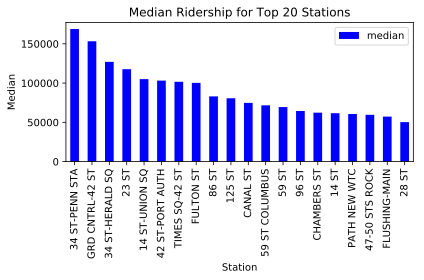

In [136]:
df_medians_top20.plot.bar(x='STATION',y='median',color='blue')
plt.xlabel('Station')
plt.ylabel('Median')
plt.title("Median Ridership for Top 20 Stations")
plt.tight_layout()
plt.savefig('medians_total.svg')
plt.show()

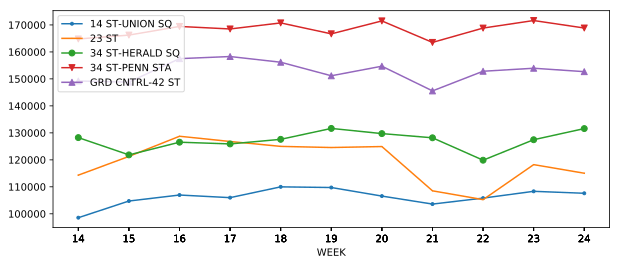

In [152]:
df_wk_medians = df_daily_sta.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DAILY_ENTRIES'], ascending=False)        
df_wk_medians['WEEK'] = pd.to_datetime(df_wk_medians['DATE'], format="%m/%d/%Y").dt.week
df_wk_medians = df_wk_medians.groupby(['STATION','WEEK'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'],ascending=False)
df_wk_medians_top5 = df_wk_medians.loc[(df_wk_medians.STATION.isin(df_medians_top5.STATION)) & (df_wk_medians.WEEK.isin(range(14,25))), :].\
reset_index().sort_values(['WEEK','STATION'])

mrk = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|"]
mrkn = 0
a = df_wk_medians_top5
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in a.groupby(['STATION']):
    mrkn = mrkn % 24
    ax = grp.plot(ax=ax, kind='line', x='WEEK', y='median', label=key, marker=mrk[mrkn], legend=None)
    mrkn +=1
    
plt.xticks(a.WEEK)
plt.legend(loc='upper left')
plt.savefig('medians_byWeek.svg')
plt.show();

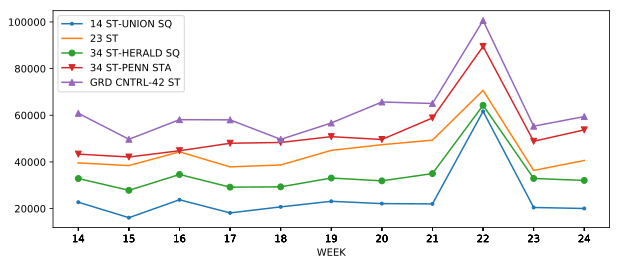

In [149]:
df_wk_iqr = df_daily_sta.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DAILY_ENTRIES'], ascending=False)        
df_wk_iqr['WEEK'] = pd.to_datetime(df_wk_iqr['DATE'], format="%m/%d/%Y").dt.week
df_wk_iqr = df_wk_iqr.groupby(['STATION','WEEK'])['DAILY_ENTRIES'].agg([stats.iqr]).reset_index().sort_values(['iqr'],ascending=False)
df_wk_iqr_top5 = df_wk_iqr.loc[(df_wk_iqr.STATION.isin(df_medians_top5.STATION)) & (df_wk_iqr.WEEK.isin(range(14,25))), :].reset_index().sort_values(['WEEK','STATION'])

b = df_wk_iqr_top5
mrkn = 0
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in b.groupby(['STATION']):
    mrkn = mrkn % 24
    ax = grp.plot(ax=ax, kind='line', x='WEEK', y='iqr', label=key, marker=mrk[mrkn])
    mrkn += 1

plt.xticks(b.WEEK)
plt.legend(loc='upper left')
plt.savefig('IQR_byWeek.svg')
plt.show();

# Weather time

In [51]:
#reading in weather data
data_w = pd.read_csv('NOAA_weather.csv', low_memory = False)

data_w = (
    data_w.rename(columns = {'AWND': 'avg_wind_spd', 'PGTM': 'peak_wind_gust_time', 'PRCP': 'precipitation', 
                            'SNOW':'snowfall', 'SNWD':'snow_depth', 'TAVG':'temp_avg', 'TMAX':'temp_max',
                            'TMIN':'temp_min', 'TOBS':'temp_moment', 'WESD':'water_on_ground', 
                            'WSF2':'wind_fst_wmin', 'WSF5':'wind_fst_5sec'})
)


In [52]:
data_w['LAT_LONG'] = [coords for coords in zip(data_w.LATITUDE, data_w.LONGITUDE)]

In [53]:
data_w.columns = [column.lower() for column in data_w.columns]

data_w.head()

,station,latitude,longitude,elevation,date,avg_wind_spd,awnd_attributes,peak_wind_gust_time,pgtm_attributes,precipitation,...,wt05_attributes,wt06,wt06_attributes,wt08,wt08_attributes,wt09,wt09_attributes,wt11,wt11_attributes,lat_long
0,US1NYWC0003,41.0639,-73.7722,71.0,2016-01-01,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.0639, -73.7722)"
1,US1NYWC0003,41.0639,-73.7722,71.0,2016-01-02,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.0639, -73.7722)"
2,US1NYWC0003,41.0639,-73.7722,71.0,2016-01-03,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.0639, -73.7722)"
3,US1NYWC0003,41.0639,-73.7722,71.0,2016-01-04,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.0639, -73.7722)"
4,US1NYWC0003,41.0639,-73.7722,71.0,2016-01-05,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.0639, -73.7722)"


In [54]:
mask = ((data_w.latitude < 40.87305) &
        (data_w.latitude > 40.57164) &
        (data_w.longitude < -73.21914) &
        (data_w.longitude > -74.0406)
       )
       

df_w = data_w.loc[mask, :]

In [55]:
df_w['date_time'] = pd.to_datetime(df_w['date'], format = "%Y-%m-%d")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
df_w['week'] = [dateobj.week for dateobj in df_w.date_time]

df_w['year'] = [dateobj.year for dateobj in df_w.date_time]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
df_w.head()

,station,latitude,longitude,elevation,date,avg_wind_spd,awnd_attributes,peak_wind_gust_time,pgtm_attributes,precipitation,...,wt08,wt08_attributes,wt09,wt09_attributes,wt11,wt11_attributes,lat_long,date_time,week,year
2382,USW00014732,40.7792,-73.88,3.4,2016-01-01,13.42,",,W",NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"(40.7792, -73.88)",2016-01-01,53,2016
2383,USW00014732,40.7792,-73.88,3.4,2016-01-02,12.53,",,W",NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"(40.7792, -73.88)",2016-01-02,53,2016
2384,USW00014732,40.7792,-73.88,3.4,2016-01-03,12.08,",,W",NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"(40.7792, -73.88)",2016-01-03,53,2016
2385,USW00014732,40.7792,-73.88,3.4,2016-01-04,18.79,",,W",NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"(40.7792, -73.88)",2016-01-04,1,2016
2386,USW00014732,40.7792,-73.88,3.4,2016-01-05,10.74,",,W",NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"(40.7792, -73.88)",2016-01-05,1,2016


In [58]:
df_w = df_w[df_w.year == 2018]

In [59]:
df_w_agg = (df_w.groupby('date')
            ['avg_wind_spd', 'precipitation', 'temp_avg', 'temp_max', 'temp_min', 'wind_fst_wmin', 'wind_fst_5sec']
            .median()
            .reset_index()
           )

In [60]:
df_w_agg = df_w_agg.rename(columns = {'wind_fst_wmin': 'wind_fst_2min'})

In [61]:
df_w_agg.head()

,date,avg_wind_spd,precipitation,temp_avg,temp_max,temp_min,wind_fst_2min,wind_fst_5sec
0,2018-01-01,12.750,0.000,12.5,18.0,7.0,20.60,28.55
1,2018-01-02,12.305,0.000,18.0,26.0,13.0,19.45,28.55
2,2018-01-03,6.035,0.000,22.0,28.0,14.0,17.00,22.45
3,2018-01-04,23.265,0.255,25.5,29.0,19.0,38.45,54.00
4,2018-01-05,22.035,0.480,16.0,20.0,9.0,32.55,44.55


In [62]:
df_w_agg['merge_date'] = [date[5:7]+'/'+date[8:]+'/'+date[0:4] for date in df_w_agg.date]

In [63]:
df_w_agg = df_w_agg.drop('date', axis = 1)

In [64]:
#merge check: setting the stage
print(df_daily.describe())
print
print(len(df_daily))
df_daily.info()

            ENTRIES  PREV_ENTRIES  DAILY_ENTRIES
count  3.944850e+05  3.897340e+05  389734.000000
mean   3.934881e+07  3.933250e+07    1182.326928
std    2.053180e+08  2.052596e+08    6532.943926
min    0.000000e+00  0.000000e+00       0.000000
25%    5.000510e+05  4.998872e+05     280.000000
50%    2.542249e+06  2.542316e+06     842.000000
75%    6.878341e+06  6.877483e+06    1625.000000
max    2.130008e+09  2.130008e+09  910999.000000
394485
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394485 entries, 0 to 394484
Data columns (total 9 columns):
C/A              394485 non-null object
UNIT             394485 non-null object
SCP              394485 non-null object
STATION          394485 non-null object
DATE             394485 non-null object
ENTRIES          394485 non-null int64
PREV_DATE        389734 non-null object
PREV_ENTRIES     389734 non-null float64
DAILY_ENTRIES    389734 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 27.1+ MB


In [65]:
df_daily_w = df_daily.merge(df_w_agg, left_on = 'DATE', right_on = 'merge_date')

In [66]:
df_daily_w =df_daily_w.drop('merge_date', axis = 1)

In [67]:
#merge check: checks out
print(df_daily_w.describe())
print
print(len(df_daily_w))
df_daily_w.info()


            ENTRIES  PREV_ENTRIES  DAILY_ENTRIES   avg_wind_spd  \
count  3.944850e+05  3.897340e+05  389734.000000  394485.000000   
mean   3.934881e+07  3.933250e+07    1182.326928       9.321539   
std    2.053180e+08  2.052596e+08    6532.943926       2.937472   
min    0.000000e+00  0.000000e+00       0.000000       4.365000   
25%    5.000510e+05  4.998872e+05     280.000000       7.270000   
50%    2.542249e+06  2.542316e+06     842.000000       8.725000   
75%    6.878341e+06  6.877483e+06    1625.000000      11.070000   
max    2.130008e+09  2.130008e+09  910999.000000      19.685000   

       precipitation       temp_avg       temp_max       temp_min  \
count  394485.000000  319395.000000  394485.000000  394485.000000   
mean        0.110252      57.028809      67.777894      51.848759   
std         0.210922      10.485391      12.607399      10.569678   
min         0.000000      38.000000      42.500000      31.000000   
25%         0.000000      47.000000      57.500000 

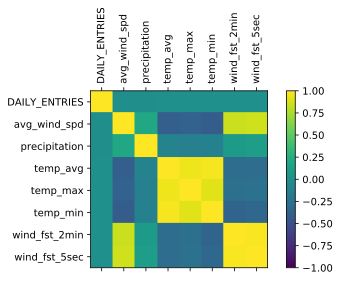

In [68]:
corrs = df_daily_w.corr().drop(['PREV_ENTRIES', 'ENTRIES'], axis = 1)
corrs = corrs.drop(['ENTRIES', 'PREV_ENTRIES'], axis = 0)
names = corrs.columns
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corrs, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation = 90)
ax.set_yticklabels(names)
plt.tight_layout()
plt.savefig('correlations.svg')

# no correlations, when does weather start to matter?

In [69]:
df_daily_w.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,avg_wind_spd,precipitation,temp_avg,temp_max,temp_min,wind_fst_2min,wind_fst_5sec
0,A002,R051,02-00-00,59 ST,03/31/2018,6566470,NaN,NaN,NaN,11.07,0.075,46.0,55.0,38.0,23.5,28.5
1,A002,R051,02-00-01,59 ST,03/31/2018,5889285,NaN,NaN,NaN,11.07,0.075,46.0,55.0,38.0,23.5,28.5
2,A002,R051,02-03-00,59 ST,03/31/2018,1056771,NaN,NaN,NaN,11.07,0.075,46.0,55.0,38.0,23.5,28.5
3,A002,R051,02-03-01,59 ST,03/31/2018,642700,NaN,NaN,NaN,11.07,0.075,46.0,55.0,38.0,23.5,28.5
4,A002,R051,02-03-02,59 ST,03/31/2018,5724868,NaN,NaN,NaN,11.07,0.075,46.0,55.0,38.0,23.5,28.5


In [70]:
# df_medians = df_daily_sta.groupby(['STATION'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'], ascending=False)        
# df_medians_top20 = df_medians[:20]

In [71]:
top_st = list(df_medians_top20['STATION'])

In [72]:

for weather_var in df_daily_w.columns[9:]:

    var_steps = (df_daily_w[weather_var].max() - df_daily_w[weather_var].min()) / 20
    var_range = np.arange(int(df_daily_w[weather_var].max()), int(df_daily_w[weather_var].min()), -var_steps)
    
#     print(weather_var, df_daily_w[weather_var].max(), var_range, var_steps)
    
    var_counter = []
    
    for var_value in var_range:
        var_counter.append(var_value)
        
        mask = (df_daily_w[weather_var].isin(var_counter))
        
        masked_df = df_daily.loc[mask, :]
        
        if len([station for station in top_st if station in list(masked_df.STATION)]) == 20:
        
            compare_st = list(masked_df.groupby(['STATION'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'], ascending=False)[:20])
        
            compare_list = list(set(compare_st) - set(top_st))
    
            if compare_list:
                print(weather_var, var_value, compare_list)

In [73]:
var_steps = (df_daily_w['temp_max'].max() - df_daily_w['temp_max'].min()) / 20
print(var_steps)

var_range = np.arange(int(df_daily_w['temp_max'].max()), int(df_daily_w['temp_max'].min()), -var_steps)
print(var_range)

2.325
[89.    86.675 84.35  82.025 79.7   77.375 75.05  72.725 70.4   68.075
 65.75  63.425 61.1   58.775 56.45  54.125 51.8   49.475 47.15  44.825
 42.5  ]


In [74]:
df_daily_w['temp_max'].isin([71.435])

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
394455    False
394456    False
394457    False
394458    False
394459    False
394460    False
394461    False
394462    False
394463    False
394464    False
394465    False
394466    False
394467    False
394468    False
394469    False
394470    False
394471    False
394472    False
394473    False
394474    False
394475    False
394476    False
394477    False
394478    False
394479    False
394480    False
394481    False
394482    False
394483    False
394484    False
Name: temp_max, Length: 